In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [2]:
GN = 6.70883*1.e-39*1.e-6

0.99


/var/folders/7n/xcfzp7ld2x3cgybk310trqrw0000gn/T/ipykernel_32906/244756628.py:150: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(t),max(t))


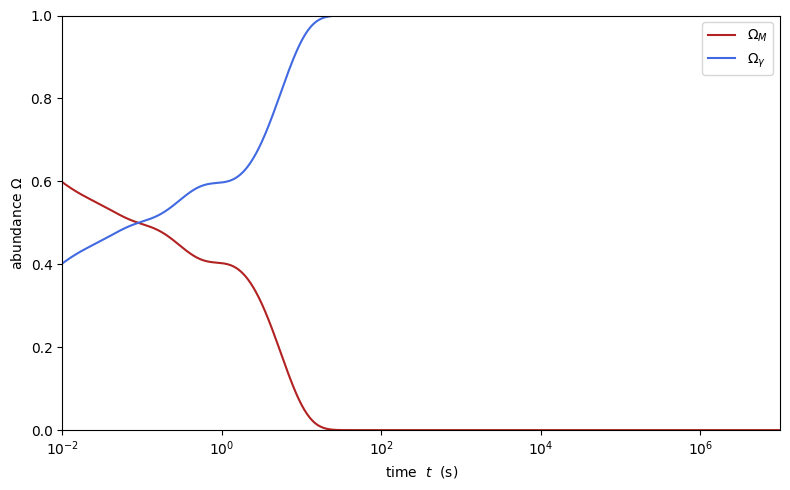

In [5]:
"""
Stasis tower + radiation in bona-fide SI seconds
------------------------------------------------
* radiation starts at ρ_γ = 35 320 MeV⁴  (T₀ = 10 MeV, g* = 10.75)
* tower adds an extra ρ_M ≃ 3.53×10⁷ MeV⁴  (tiny_radiation = 10⁻³)
* Γ/H for the heaviest mode is 0.01 at t₀
* ODE is solved with t in **seconds**
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# ------------------------------------------------------------------
# Physical constants and helpers
# ------------------------------------------------------------------
HBAR_MEV_S = 6.582119569e-22             # ħ (MeV·s)
MPL_MEV    = 1.2209e22                     # reduced Planck mass (MeV)

def mev_to_inv_s(x_mev):
    """Convert an energy (MeV) to a frequency (s⁻¹)."""
    return x_mev / HBAR_MEV_S


# ------------------------------------------------------------------
# 1.  Model parameters
# ------------------------------------------------------------------
alpha   = 1
gamma   = 7
delta   = 1
m0      = 1            # 1 GeV in MeV
Delta_m = m0
N_SPECIES = 5 #10
GAMMA_OVER_H = 1#1e6        # Γ/H of the *heaviest* species at t₀

T0_MEV   = 10.0
g_star   = 10.75
rho_gamma0 = (np.pi**2/30) * g_star * T0_MEV**4     # 35 320 MeV⁴

#rho_gamma0 = 29606.63436125509  #test 

tiny_radiation = 0.01      # ρ_γ / ρ_tot  at t₀
#tiny_radiation = 0.01190693     #test
tiny_radiation  = 1-0.9880930653994693  #test
tiny_radiation = 0.01
rho_tot0 = rho_gamma0 / tiny_radiation
#rho_tot0 = 2960663.436125509        #test
rho_M0   = rho_tot0 - rho_gamma0
#rho_M0 =   2931056.801764254  #test

ell      = np.arange(N_SPECIES)
m_ell    = m0 + Delta_m*(ell+1)**delta

omega_ell_frac = (m_ell/m0)**alpha #0.99 is test
omega_ell_frac /= omega_ell_frac.sum()
omega_ell_frac*=(1-tiny_radiation)
print(sum(omega_ell_frac))
rho_ell0 = omega_ell_frac * rho_M0                 # vector (MeV⁴)
#rho_ell0 = np.array([195403.78678428, 390807.57356857, 586211.36035285, 781615.14713713, 977018.93392142])   #test


# ------------------------------------------------------------------
# 2.  Decay widths  (Γ in s⁻¹)
# ------------------------------------------------------------------
H0_mev   = np.sqrt(rho_tot0) / (np.sqrt(3)*MPL_MEV)    # MeV
H0_mev = np.sqrt(rho_tot0*8*np.pi*GN/3)     #test
H0_s     = mev_to_inv_s(H0_mev)                        # s⁻¹

m_Nm1    = m_ell[-1]
Gamma0_mev = (GAMMA_OVER_H / (m_Nm1/m0)**gamma) * H0_mev
Gamma_ell = Gamma0_mev * (m_ell/m0)**gamma            # MeV
Gamma_ell_s = mev_to_inv_s(Gamma_ell)                 # s⁻¹


# ------------------------------------------------------------------
# 3.  Initial state (log-densities)  — still *in MeV⁴*
# ------------------------------------------------------------------
chi_ell0   = np.log(rho_ell0)
chi_gamma0 = np.log(rho_gamma0)
N0         = 0.0

y0 = np.concatenate([chi_ell0, [chi_gamma0, N0]])

Htot = []
ttot = []
# ------------------------------------------------------------------
# 4.  ODE system with t in seconds
# ------------------------------------------------------------------
def ode_system(t, y):
    chi_ell   = y[:N_SPECIES]
    chi_gamma = y[N_SPECIES]
    N         = y[N_SPECIES+1]

    rho_ell = np.exp(chi_ell)           # still MeV⁴
    rho_g   = np.exp(chi_gamma)
    rho_tot = rho_ell.sum() + rho_g
    H_mev = np.sqrt(rho_tot*8*np.pi*GN/3)   # MeV
    #H_mev = H_interp_func(t)    #values from prymordial
    #print(H_mev)
    Htot.append(H_mev)
    ttot.append(t)
    #H_mev = H1
    H_s   = mev_to_inv_s(H_mev)                       # convert to s⁻¹


    dchi_ell   = -3.0*H_s - Gamma_ell_s
    dchi_gamma = -4.0*H_s + np.sum(Gamma_ell_s * np.exp(chi_ell - chi_gamma))
    dNdt       = H_s

    return np.concatenate([dchi_ell, [dchi_gamma, dNdt]])


# ------------------------------------------------------------------
# 5.  Integrate up to 1 s  (covers the entire BBN window)
# ------------------------------------------------------------------
t_span = (0, 10000000)#t_span = (0.0, 1e18)            # seconds
#0.00738652
sol = solve_ivp(
    ode_system,
    t_span,
    y0,
    method='BDF',
    rtol=1e-8,
    atol=1e-12
)


# ------------------------------------------------------------------
# 6.  Unpack & plot
# ------------------------------------------------------------------
t = sol.t                       # seconds
rho_ell = np.exp(sol.y[:N_SPECIES])
rho_g   = np.exp(sol.y[N_SPECIES])
rho_tot = rho_ell.sum(axis=0) + rho_g

Hubble = np.sqrt(rho_tot*(8*np.pi*GN/3))
Omega_M = rho_ell.sum(axis=0) / rho_tot    
Omega_g = rho_g                / rho_tot

plt.figure(figsize=(8,5))
plt.semilogx(t, Omega_M, label=r'$\Omega_M$', color='firebrick')
plt.semilogx(t, Omega_g, label=r'$\Omega_\gamma$', color='royalblue')
plt.xlabel(r'time  $t$  (s)')
plt.ylabel(r'abundance $\Omega$')
#plt.title('Matter–Radiation Stasis  Abundances')
plt.ylim(1e-4, 1.05)

# plt.xlim(1e-10, 1e3)
plt.xlim(min(t),max(t))
plt.xlim(1e-2,1e7)
plt.ylim(0,1)
#plt.axvline(x=1e0, color='black', linestyle='--', label='t = 1 sec')

plt.legend()
plt.tight_layout()
plt.show()


In [6]:
Omega_M[0]

0.98990001009999

In [7]:
sum(omega_ell_frac)

0.99

In [8]:
sum(Omega_M)

296.61805951441755

In [9]:
rho_ell0


array([ 231081.98264491,  462163.96528981,  693245.94793472,
        924327.93057962, 1155409.91322453])

/var/folders/7n/xcfzp7ld2x3cgybk310trqrw0000gn/T/ipykernel_32906/2634591071.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(t),max(t))


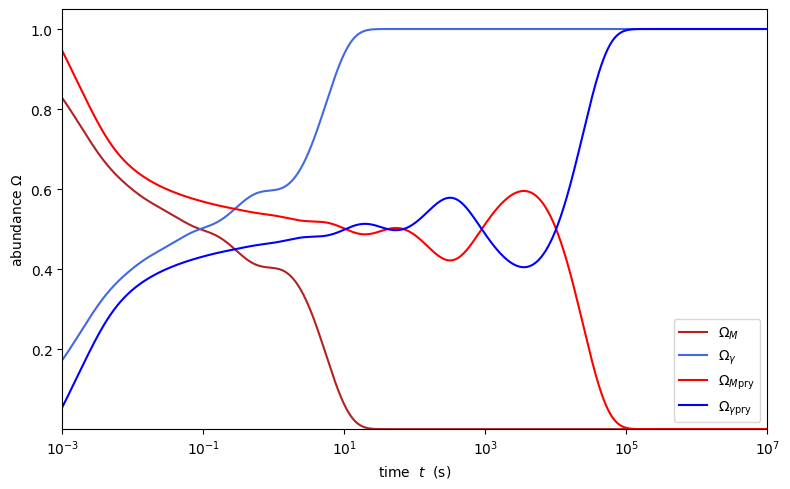

In [6]:
t1, Tg1, rho_tot1, rho_rad1, rho_dm1, Omega_m1, Omega_rad1= \
    np.loadtxt("../PRyMrates/thermo/stasis_abundances.txt", unpack=True, skiprows=1)



plt.figure(figsize=(8,5))
plt.semilogx(t, np.array(Omega_M), label=r'$\Omega_M$', color='firebrick')
plt.semilogx(t, np.array(Omega_g), label=r'$\Omega_\gamma$', color='royalblue')
plt.semilogx(t1, Omega_m1, label=r'$\Omega_{M \rm{pry}}$', color='red')
plt.semilogx(t1, Omega_rad1, label=r'$\Omega_{\gamma \rm{pry}}$', color='blue')
plt.xlabel(r'time  $t$  (s)')
plt.ylabel(r'abundance $\Omega$')
#plt.title('Matter–Radiation Stasis  Abundances')
plt.ylim(1e-4, 1.05)

# plt.xlim(1e-10, 1e3)
plt.xlim(min(t),max(t))
plt.xlim(1e-3,1e7)
#plt.xlim(1e-2,1e7)
#plt.ylim(0,1)
#plt.axvline(x=1e0, color='black', linestyle='--', label='t = 1 sec')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from scipy.interpolate import interp1d
t1, Tg1, rho_tot1, rho_rad1, rho_dm1, Omega_m1, Omega_rad1,H= \
    np.loadtxt("../PRyMrates/thermo/stasis_abundances.txt", unpack=True, skiprows=1)
# Create interpolation function
H_interp_func = interp1d(t1, H, kind='linear', fill_value='extrapolate')  # or kind='cubic', etc.

# Interpolate H over t1
H1 = H_interp_func(t)

plt.plot(t,H1)
#plt.plot(t,Hubble)
#plt.plot(t1,H)
plt.plot(ttot,np.array(Htot)*1.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0,max(t1))

In [ ]:
print(Omega_M[0],Omega_m1[0])
print(min(t1),min(t))


0.9879513106473617 0.9879742
0.00738652 0.0


/var/folders/7n/xcfzp7ld2x3cgybk310trqrw0000gn/T/ipykernel_25144/3690188549.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(t),max(t))
/var/folders/7n/xcfzp7ld2x3cgybk310trqrw0000gn/T/ipykernel_25144/3690188549.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000)


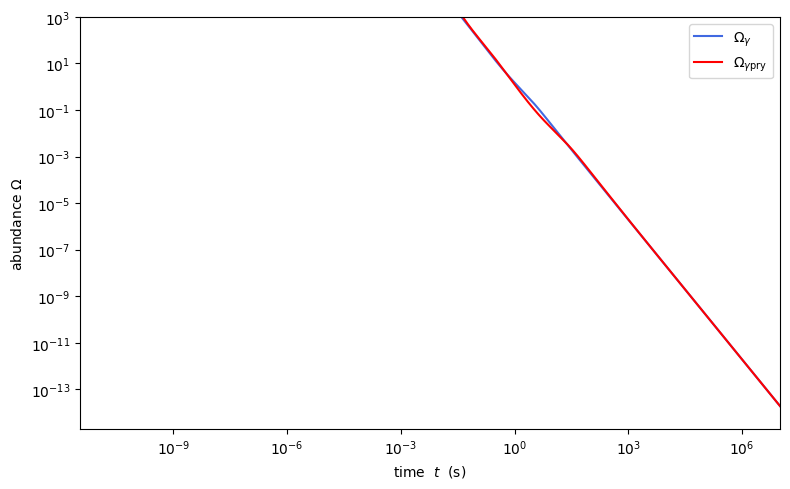

In [ ]:
t1, Tg1, rho_tot1, rho_rad1, rho_dm1, Omega_m1, Omega_rad1,H= \
    np.loadtxt("../PRyMrates/thermo/stasis_abundances.txt", unpack=True, skiprows=1)



plt.figure(figsize=(8,5))
#plt.semilogx(t, np.array(Omega_M), label=r'$\Omega_M$', color='firebrick')
#plt.semilogx(t1, Omega_m1, label=r'$\Omega_{M \rm{pry}}$', color='red')
#plt.semilogx(t1, rho_dm1*1, label=r'$\Omega_{\gamma \rm{pry}}$', color='red')
#plt.semilogx(t, rho_ell.sum(axis=0), label=r'$\Omega_\gamma$', color='royalblue')
plt.semilogx(t, rho_g, label=r'$\Omega_\gamma$', color='royalblue')
plt.semilogx(t1, rho_rad1, label=r'$\Omega_{\gamma \rm{pry}}$', color='red')
#plt.semilogx(t, np.array(rho_g)/np.array(rho_tot), label=r'$\Omega_\gamma$', color='royalblue')
#plt.semilogx(t1, np.array(rho_rad1)/np.array(rho_tot1), label=r'$\Omega_{\gamma \rm{pry}}$', color='red')
#plt.semilogx(t, rho_tot, label=r'$\Omega_\gamma$', color='royalblue')
#plt.semilogx(t1, rho_tot1, label=r'$\Omega_{\gamma \rm{pry}}$', color='red')
plt.xlabel(r'time  $t$  (s)')
plt.ylabel(r'abundance $\Omega$')
#plt.title('Matter–Radiation Stasis  Abundances')
#plt.ylim(1e-4, 1.05)
plt.yscale('log')
# plt.xlim(1e-10, 1e3)
plt.xlim(min(t),max(t))
plt.ylim(0,1000)
#plt.xlim(1e-2,1e7)
#plt.ylim(0,1)
#plt.axvline(x=1e0, color='black', linestyle='--', label='t = 1 sec')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/7n/xcfzp7ld2x3cgybk310trqrw0000gn/T/ipykernel_25144/1780323749.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min(H1),max(H1))


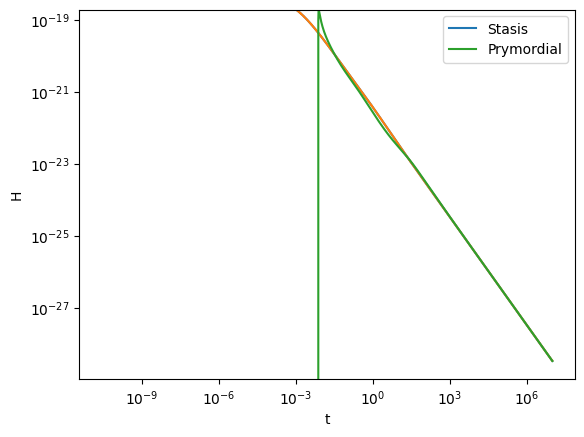

In [ ]:
plt.plot(t,Hubble,label = 'Stasis')
plt.plot(ttot,Htot)
plt.plot(t,H1,label = 'Prymordial')
plt.yscale('log')
plt.xscale('log')
plt.ylim(min(H1),max(H1))
#plt.xlim(0,max(t1)*.2*.2)
plt.ylabel('H')
plt.xlabel('t')
plt.legend()
plt.savefig('H_vs_t.pdf')